# Vehicle Routing Problem
## v0.1.1
Problem Scenario: Define a small VRP scenario with a limited number of vehicles
and locations. For example, consider a delivery scenario with 1 depot, 2 vehicles, and
5–10 customer locations. Each vehicle starts and ends at the depot and must visit a
subset of customers.

Objective: Clearly state the objective of the VRP. Typically, the goal is to minimize
the total distance or travel time for all routes while ensuring every customer is visited
exactly once. (For simplicity, you may ignore advanced constraints like vehicle
capacity or time windows unless you choose to include them.).

Example Data: Provide or describe a small example dataset for the VRP. This could
be a list of customer locations (with coordinates or a distance matrix between all
locations) and the depot location. For instance, you might give coordinates for each
location and have distances computed as Euclidean distances, or supply a distance
matrix for a set of locations. Make sure the example is easy to understand (e.g., a small
table of distances or a simple map of points).

In [ ]:
import random
from typing import List, Tuple
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
print('Matplotlib version:', matplotlib.__version__)
print('NumPy version:', np.__version__)

Matplotlib version: 3.10.3
NumPy version: 2.3.1


In [399]:
depot_coordinates = np.array([0, 0])

nr_clients = 10
# client_coordinates = [np.array([np.random.randint(1,9), np.random.randint(1,9)]) for _ in range(nr_clients)]
client_coordinates = [
    np.array([5, 2]), np.array([2, 7]), np.array([2, 8]), np.array([4, 6]), np.array([1, 4]), np.array([3, 4]), np.array([4, 3]), np.array([2, 2]), np.array([7, 7]), np.array([7, 3])
]
print("Client coordinates:\n", client_coordinates)
print("Depot coordinates:\n", depot_coordinates)

Client coordinates:
 [array([5, 2]), array([2, 7]), array([2, 8]), array([4, 6]), array([1, 4]), array([3, 4]), array([4, 3]), array([2, 2]), array([7, 7]), array([7, 3])]
Depot coordinates:
 [0 0]


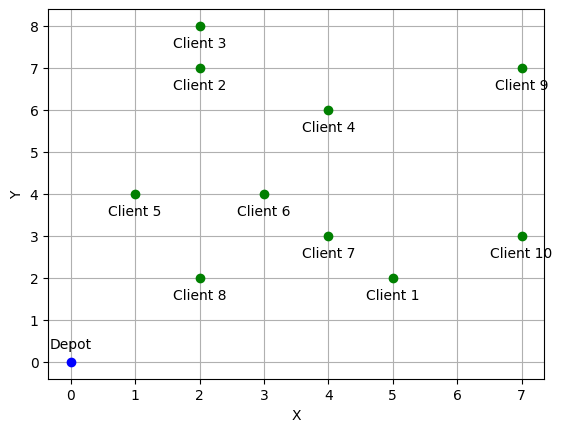

In [400]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(nr_clients):
    plt.plot(client_coordinates[i][0],client_coordinates[i][1], 'o', color='green')
    ax.annotate(f'Client {i+1}', (client_coordinates[i][0], client_coordinates[i][1]), textcoords="offset points", xytext=(0,-15), ha='center')
plt.plot(depot_coordinates[0],depot_coordinates[1], 'o', color='blue')
ax.annotate('Depot', (depot_coordinates[0], depot_coordinates[1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('X')
plt.ylabel('Y')

plt.grid()

In [401]:
def euclidean_distance(coord1, coord2):
    return np.linalg.norm(coord1 - coord2)
def calculate_distance_matrix(client_coordinates, depot_coordinates):
    nr_clients = len(client_coordinates)
    distance_matrix = np.zeros((nr_clients + 1, nr_clients + 1))
    
    for i in range(nr_clients):
        distance_matrix[0][i + 1] = euclidean_distance(depot_coordinates, client_coordinates[i])
        distance_matrix[i + 1][0] = distance_matrix[0][i + 1]
        
        for j in range(i + 1, nr_clients):
            distance_matrix[i + 1][j + 1] = euclidean_distance(client_coordinates[i], client_coordinates[j])
            distance_matrix[j + 1][i + 1] = distance_matrix[i + 1][j + 1]
    
    return distance_matrix

In [402]:
print("Distance matrix:\n", calculate_distance_matrix(client_coordinates, depot_coordinates))

Distance matrix:
 [[0.         5.38516481 7.28010989 8.24621125 7.21110255 4.12310563
  5.         5.         2.82842712 9.89949494 7.61577311]
 [5.38516481 0.         5.83095189 6.70820393 4.12310563 4.47213595
  2.82842712 1.41421356 3.         5.38516481 2.23606798]
 [7.28010989 5.83095189 0.         1.         2.23606798 3.16227766
  3.16227766 4.47213595 5.         5.         6.40312424]
 [8.24621125 6.70820393 1.         0.         2.82842712 4.12310563
  4.12310563 5.38516481 6.         5.09901951 7.07106781]
 [7.21110255 4.12310563 2.23606798 2.82842712 0.         3.60555128
  2.23606798 3.         4.47213595 3.16227766 4.24264069]
 [4.12310563 4.47213595 3.16227766 4.12310563 3.60555128 0.
  2.         3.16227766 2.23606798 6.70820393 6.08276253]
 [5.         2.82842712 3.16227766 4.12310563 2.23606798 2.
  0.         1.41421356 2.23606798 5.         4.12310563]
 [5.         1.41421356 4.47213595 5.38516481 3.         3.16227766
  1.41421356 0.         2.23606798 5.         3.

# Evolutionary Algorithm



In [403]:
# ======= Helper: Distance matrix =======
def calculate_distance_matrix(client_coords, depot_coords):
    all_points = [depot_coords] + client_coords
    n = len(all_points)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i][j] = np.linalg.norm(all_points[i] - all_points[j])
    return dist_matrix

# ======= Population Initialization =======
def initialize_population(pop_size, nr_clients, nr_vehicles):
    population = []
    customers = list(range(1, nr_clients + 1))  # IDs 1..n
    for _ in range(pop_size):
        random.shuffle(customers)
        # split into roughly equal parts
        splits = np.array_split(customers, nr_vehicles)
        route = []
        for s in splits:
            route.append(0)
            route.extend(s.tolist())
        route.append(0)
        population.append(route)
    return population

# ======= Cost Calculation =======
def calculate_cost(route, distance_matrix):
    cost = 0
    for i in range(len(route) - 1):
        cost += distance_matrix[route[i]][route[i + 1]]
    return cost

# ======= Selection =======
def selection(population, distance_matrix, num_select):
    population.sort(key=lambda r: calculate_cost(r, distance_matrix))
    return population[:num_select]

# ======= Crossover (VRP-aware) =======
def crossover(parent1, parent2, nr_vehicles):
    # Remove depots
    p1_customers = [c for c in parent1 if c != 0]
    p2_customers = [c for c in parent2 if c != 0]
    
    # OX Crossover
    size = len(p1_customers)
    start, end = sorted(random.sample(range(size), 2))
    child = [None] * size
    child[start:end+1] = p1_customers[start:end+1]
    
    fill_positions = [i for i in range(size) if child[i] is None]
    fill_values = [c for c in p2_customers if c not in child]
    for pos, val in zip(fill_positions, fill_values):
        child[pos] = val
    
    # Split into vehicles randomly
    splits = np.array_split(child, nr_vehicles)
    route = []
    for s in splits:
        route.append(0)
        route.extend(s.tolist())
    route.append(0)
    return route

# ======= Mutation =======
def mutate(route, nr_vehicles, mutation_rate=0.1):
    # Remove depots
    customers = [c for c in route if c != 0]
    for i in range(len(customers)):
        if random.random() < mutation_rate:
            j = random.randint(0, len(customers) - 1)
            customers[i], customers[j] = customers[j], customers[i]
    # Re-split
    splits = np.array_split(customers, nr_vehicles)
    new_route = []
    for s in splits:
        new_route.append(0)
        new_route.extend(s.tolist())
    new_route.append(0)
    return new_route

# ======= Main Evolution =======
def evolve(distance_matrix, nr_clients, nr_vehicles, pop_size=50, generations=100):
    population = initialize_population(pop_size, nr_clients, nr_vehicles)
    
    best_route = None
    best_cost = float('inf')
    cost_progress = []
    
    for gen in range(generations):
        # Selection
        population = selection(population, distance_matrix, pop_size // 2)
        
        # Crossover + Mutation to refill
        children = []
        while len(children) < pop_size - len(population):
            parents = random.sample(population, 2)
            child = crossover(parents[0], parents[1], nr_vehicles)
            child = mutate(child, nr_vehicles)
            children.append(child)
        
        population += children
        
        # Track best
        current_best = min(population, key=lambda r: calculate_cost(r, distance_matrix))
        current_cost = calculate_cost(current_best, distance_matrix)
        cost_progress.append(current_cost)
        
        if current_cost < best_cost:
            best_cost = current_cost
            best_route = current_best
        
        print(f"Gen {gen+1}: Best Cost = {best_cost:.2f}")
    
    return best_route, best_cost, cost_progress

nr_vehicles = 2

best_route, best_cost, cost_progress = evolve(distance_matrix, nr_clients, nr_vehicles, pop_size=30, generations=30)
print("Best Route:", best_route)
print("Best Cost:", best_cost)

Gen 1: Best Cost = 46.07
Gen 2: Best Cost = 46.07
Gen 3: Best Cost = 42.10
Gen 4: Best Cost = 42.10
Gen 5: Best Cost = 42.10
Gen 6: Best Cost = 42.10
Gen 7: Best Cost = 42.10
Gen 8: Best Cost = 42.10
Gen 9: Best Cost = 41.13
Gen 10: Best Cost = 41.13
Gen 11: Best Cost = 41.13
Gen 12: Best Cost = 41.13
Gen 13: Best Cost = 41.13
Gen 14: Best Cost = 41.13
Gen 15: Best Cost = 40.75
Gen 16: Best Cost = 40.75
Gen 17: Best Cost = 40.75
Gen 18: Best Cost = 40.26
Gen 19: Best Cost = 40.26
Gen 20: Best Cost = 40.26
Gen 21: Best Cost = 40.26
Gen 22: Best Cost = 40.26
Gen 23: Best Cost = 40.26
Gen 24: Best Cost = 40.26
Gen 25: Best Cost = 40.26
Gen 26: Best Cost = 40.26
Gen 27: Best Cost = 40.26
Gen 28: Best Cost = 40.26
Gen 29: Best Cost = 40.26
Gen 30: Best Cost = 40.26
Best Route: [0, 8, 6, 2, 3, 5, 0, 7, 4, 9, 10, 1, 0]
Best Cost: 40.25649445845235


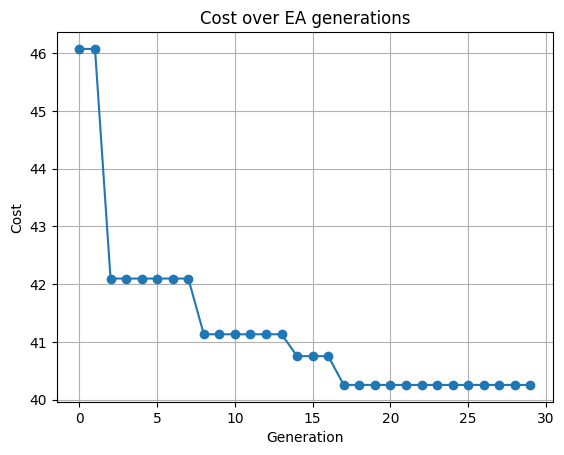

In [404]:
plt.plot(range(len(cost_progress)), cost_progress, marker='o')
plt.title('Cost over EA generations')
plt.xlabel('Generation')
plt.ylabel('Cost')
plt.grid()

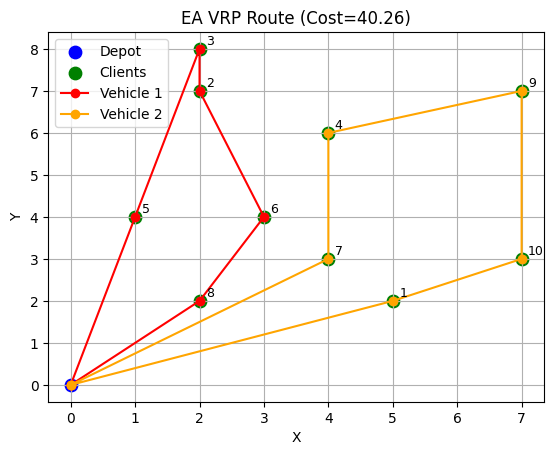

In [405]:
# === PLOT BEST ROUTE ===
colors = [ 'red','orange' ]
fig, ax = plt.subplots()
pts = np.vstack([depot_coordinates.reshape(1,2), client_coordinates])
ax.scatter(pts[0,0], pts[0,1], c='blue', s=80, label='Depot')
ax.scatter(pts[1:,0], pts[1:,1], c='green',s=80, label='Clients')

for i, coord in enumerate(client_coordinates, start=1):
    plt.scatter(coord[0], coord[1], c='gray')
    plt.text(coord[0]+0.1, coord[1]+0.1, str(i), fontsize=9)


# Split route into segments per vehicle
segments = []
current_seg = []
for node in best_route:
    if node == 0:
        if current_seg:
            segments.append(current_seg)
            current_seg = []
    else:
        current_seg.append(node)
if current_seg:
    segments.append(current_seg)

# Plot each vehicle's path
for v, seg in enumerate(segments):
    xs = [depot_coordinates[0]] + [client_coordinates[c-1][0] for c in seg] + [depot_coordinates[0]]
    ys = [depot_coordinates[1]] + [client_coordinates[c-1][1] for c in seg] + [depot_coordinates[1]]
    plt.plot(xs, ys, '-o', color=colors[v % len(colors)], label=f'Vehicle {v+1}')


plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'EA VRP Route (Cost={best_cost:.2f})')
plt.legend()
plt.grid(True)
plt.show()

# Quantum Inspired Evolutionary Algorithm

In [406]:
"""
Quantum-Inspired Evolutionary Algorithm (QIEA) for a small VRP (multi-vehicle).

- Representation: position-based probability matrix P (n x n) where P[i,j] is
  the probability that customer j is placed at position i (0-indexed).
- Sampling: collapse P into permutations (sample without replacement).
- Decoding: split permutation into K vehicle routes (balanced split by default).
- Update: rotation-style update (increase probability of assignments present
  in best sample; decrease others), with row renormalization.
- Optional: small random noise injection to prevent premature collapse.
- Metrics: best cost per iteration (convergence history), evaluations count.
"""

def calculate_distance_matrix(clients: np.ndarray, depot: np.ndarray) -> np.ndarray:
    """
    Build distance matrix D of size (n+1)x(n+1),
    index 0 = depot, indices 1..n = clients.
    """
    pts = np.vstack([depot.reshape(1,2), clients])
    n = len(pts)
    D = np.linalg.norm(pts[:,None,:] - pts[None,:,:], axis=2)
    return D

def split_perm_to_routes(perm: List[int], K: int) -> List[List[int]]:
    """
    Balanced split of a permutation of client IDs (1..n) into K routes.
    perm: list of client ids (1..n)
    Returns: list of routes, each route is list of client ids (1..n)
    """
    n = len(perm)
    sizes = [n // K + (1 if i < (n % K) else 0) for i in range(K)]
    routes = []
    idx = 0
    for s in sizes:
        if s > 0:
            routes.append(perm[idx: idx + s])
        else:
            routes.append([])
        idx += s
    return routes

def route_cost(route: List[int], D: np.ndarray) -> float:
    """
    route: list of client ids (1..n)
    D: distance matrix with 0 = depot
    Returns route cost including depot->first and last->depot.
    """
    if len(route) == 0:
        return 0.0
    cost = 0.0
    prev = 0  # depot
    for c in route:
        cost += D[prev, c]
        prev = c
    cost += D[prev, 0]
    return cost

def total_cost_from_perm(perm: List[int], K: int, D: np.ndarray) -> float:
    """
    perm: list of client ids (1..n), length n
    K: number of vehicles
    D: distance matrix
    """
    routes = split_perm_to_routes(perm, K)
    return sum(route_cost(r, D) for r in routes)

# ---------------------------
# Sampling from P (Q-bits)
# ---------------------------
def sample_permutation_from_P(P: np.ndarray, rng: np.random.Generator) -> List[int]:
    """
    Sample a permutation from the position-based probability matrix P (n x n).
    P rows are positions 0..n-1, columns correspond to client indices 1..n mapped to 0..n-1.
    To reduce positional bias, we fill positions in a random order per sample,
    picking a client according to the (masked & normalized) probabilities for that position.
    Returns a list of client ids in range 1..n.
    """
    n = P.shape[0]
    perm = [None] * n
    used = np.zeros(n, dtype=bool)
    pos_order = rng.permutation(n)  # random filling order to reduce bias
    for pos in pos_order:
        probs = P[pos].copy()
        probs[used] = 0.0
        s = probs.sum()
        if s <= 0:
            # fallback: choose a random unused client
            choices = np.where(~used)[0]
            pick = rng.choice(choices)
        else:
            probs /= s
            pick = rng.choice(n, p=probs)
        perm[pos] = int(pick + 1)  # client ids are 1..n
        used[pick] = True
    # perm array has client ids but may be unordered by positions; reorder by positions 0..n-1
    ordered = [perm[i] for i in range(n)]
    return ordered

# ---------------------------
# Rotation-style update
# ---------------------------
def update_probability_matrix(P: np.ndarray, best_perm: List[int], delta: float) -> np.ndarray:
    """
    Increase probabilities P[i, best_city-1] and decrease others proportionally on each row.
    P is modified in-place (but function returns P too).
    delta is step in (0,1).
    """
    n = P.shape[0]
    for i in range(n):
        target_col = best_perm[i] - 1  # convert client id to column index 0..n-1
        # Increase target entry toward 1
        P[i, target_col] = min(1.0, P[i, target_col] + delta * (1.0 - P[i, target_col]))
        # Decrease others
        for j in range(n):
            if j != target_col:
                P[i, j] = max(0.0, P[i, j] - delta * P[i, j])
        # Renormalize row
        s = P[i].sum()
        if s <= 0:
            P[i] = np.full(n, 1.0 / n)
        else:
            P[i] /= s
    return P

# ---------------------------
# Small 2-opt on each route
# ---------------------------
def two_opt_route(route: List[int], D: np.ndarray) -> Tuple[List[int], float]:
    """
    Apply 2-opt locally on a single route (list of client ids 1..n).
    Returns improved route and its cost.
    Simple implementation: stop after no improvement found (first-improvement).
    """
    best = route[:]
    best_cost = route_cost(best, D)
    improved = True
    n = len(route)
    while improved:
        improved = False
        for i in range(0, n - 1):
            for j in range(i + 1, n):
                candidate = best[:]
                candidate[i:j+1] = list(reversed(candidate[i:j+1]))
                c = route_cost(candidate, D)
                if c < best_cost - 1e-9:
                    best = candidate
                    best_cost = c
                    improved = True
                    break
            if improved:
                break
    return best, best_cost

# ---------------------------
# QIEA main
# ---------------------------
def qiea_vrp(
    D: np.ndarray,
    K: int,
    iters: int = 200,
    samples_per_iter: int = 50,
    delta: float = 0.02,
    noise_prob: float = 0.02,
    noise_strength: float = 0.02,
    local_search: bool = True,
    rng_seed: int = 0,
    verbose: bool = True
) -> dict:
    """
    Run the Quantum-Inspired Evolutionary Algorithm on VRP instance.
    D: distance matrix (0=depot, 1..n clients)
    K: number of vehicles
    Returns dictionary with results: best_perm (client ids 1..n), best_cost, history, evals
    """
    rng = np.random.default_rng(rng_seed)
    n_clients = D.shape[0] - 1
    # Initialize probability matrix P (n x n)
    P = np.full((n_clients, n_clients), 1.0 / n_clients)
    best_perm = None
    best_cost = float('inf')
    history = []
    evals = 0

    for t in range(iters):
        # Sample a batch of permutations
        batch = []
        for s in range(samples_per_iter):
            perm = sample_permutation_from_P(P, rng)  # list of client ids 1..n
            # decode and optionally local search on each route
            if local_search:
                # transform perm -> routes, apply 2-opt to each route
                routes = split_perm_to_routes(perm, K)
                improved_perm = []
                for r in routes:
                    if len(r) <= 1:
                        improved_perm.extend(r)
                    else:
                        r_opt, _ = two_opt_route(r, D)
                        improved_perm.extend(r_opt)
            else:
                improved_perm = perm
            cost = total_cost_from_perm(improved_perm, K, D)
            batch.append((improved_perm, cost))
            evals += 1

            if cost < best_cost:
                best_cost = cost
                best_perm = improved_perm[:]

        # Choose best in batch and update P towards it
        batch_best_perm, batch_best_cost = min(batch, key=lambda x: x[1])
        # update using rotation-inspired rule
        adaptive_delta = delta  # could adapt using (some function of batch costs)
        P = update_probability_matrix(P, batch_best_perm, adaptive_delta)

        # Occasionally inject noise to maintain exploration
        if rng.random() < noise_prob:
            noise = rng.random(size=P.shape)
            P = (1.0 - noise_strength) * P + noise_strength * noise
            # renormalize each row
            row_sums = P.sum(axis=1, keepdims=True)
            row_sums[row_sums == 0] = 1.0
            P = P / row_sums

        history.append(best_cost)
        if verbose and (t % max(1, iters//10) == 0 or t == iters-1):
            print(f"Iter {t+1}/{iters}: evals={evals}, best_cost={best_cost:.4f}")

    return {
        "best_perm": best_perm,      # list of client ids 1..n
        "best_cost": best_cost,
        "history": history,
        "evals": evals,
        "P": P
    }

# ---------------------------
# Demo run & plotting
# ---------------------------

depot, clients = depot_coordinates, client_coordinates
D = calculate_distance_matrix(clients, depot)
K = 2

result = qiea_vrp(D, K, iters=30, samples_per_iter=40, delta=0.03,
                    noise_prob=0.05, noise_strength=0.02,
                    local_search=True, rng_seed=12345, verbose=True)

print("\nFinal best cost:", result["best_cost"])
print("Best permutation (client ids):", result["best_perm"])
# Show routes
routes = split_perm_to_routes(result["best_perm"], K)
for idx, r in enumerate(routes):
    print(f"Route {idx+1}:", [0] + r + [0], " cost:", route_cost(r, D))

Iter 1/30: evals=40, best_cost=40.6665
Iter 4/30: evals=160, best_cost=40.0356
Iter 7/30: evals=280, best_cost=40.0356
Iter 10/30: evals=400, best_cost=40.0356
Iter 13/30: evals=520, best_cost=40.0356
Iter 16/30: evals=640, best_cost=40.0356
Iter 19/30: evals=760, best_cost=40.0356
Iter 22/30: evals=880, best_cost=40.0356
Iter 25/30: evals=1000, best_cost=40.0356
Iter 28/30: evals=1120, best_cost=40.0356
Iter 30/30: evals=1200, best_cost=40.0356

Final best cost: 40.0356062749123
Best permutation (client ids): [8, 7, 9, 10, 1, 5, 2, 3, 4, 6]
Route 1: [0, 8, 7, 9, 10, 1, 0]  cost: 21.685727886880276
Route 2: [0, 5, 2, 3, 4, 6, 0]  cost: 18.349878388032018


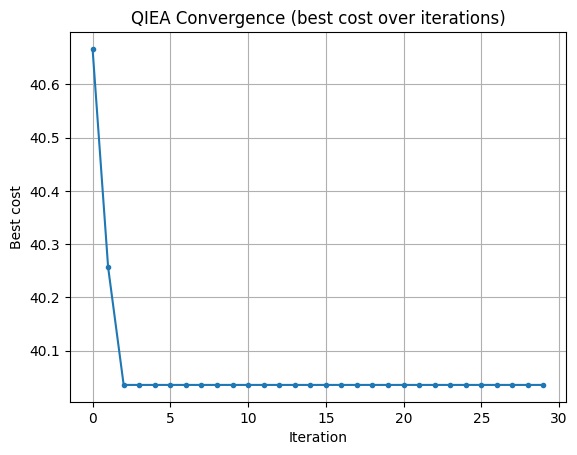

In [407]:
# plot convergence
plt.plot(result["history"], marker='o', markersize=3)
plt.xlabel("Iteration")
plt.ylabel("Best cost")
plt.title("QIEA Convergence (best cost over iterations)")
plt.grid(True)
plt.show()

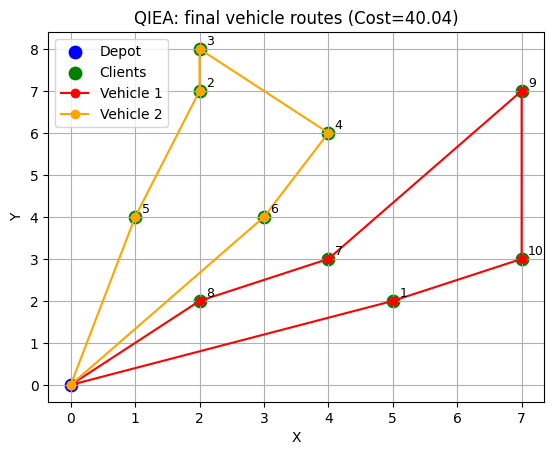

In [408]:
# plot routes on map
fig, ax = plt.subplots()
pts = np.vstack([depot.reshape(1,2), clients])
ax.scatter(pts[0,0], pts[0,1], c='blue', s=80, label='Depot')
ax.scatter(pts[1:,0], pts[1:,1], c='green',s=80, label='Clients')
for i, coord in enumerate(client_coordinates, start=1):
    plt.scatter(coord[0], coord[1], c='gray')
    plt.text(coord[0]+0.1, coord[1]+0.1, str(i), fontsize=9)
colors = ['red', 'orange', 'purple', 'cyan', 'magenta']
for i, r in enumerate(routes):
    xs = [depot[0]] + [clients[c-1][0] for c in r] + [depot[0]]
    ys = [depot[1]] + [clients[c-1][1] for c in r] + [depot[1]]
    ax.plot(xs, ys, '-o', color=colors[i % len(colors)], label=f'Vehicle {i+1}')
ax.legend()
plt.xlabel('X')
plt.ylabel('Y')
ax.set_title(f'QIEA: final vehicle routes (Cost={result["best_cost"]:.2f})')
ax.grid(True)
plt.show()